In [1]:
#%%
# Import required modules
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.mixture_same_family import MixtureSameFamily
from torch.distributions.normal import Normal
from torch.distributions.categorical import Categorical
from torch.distributions.independent import Independent
from lightning_data_modules.SyntheticDataset import SyntheticDataModule
from configs.jan.GaussianBubbles import get_config
from lightning_modules.BaseSdeGenerativeModel import BaseSdeGenerativeModel
from lightning_modules.ConservativeSdeGenerativeModel import ConservativeSdeGenerativeModel
from models.fcn import FCN
from models.utils import get_score_fn
from utils import compute_divergence, compute_grad, compute_curl

In [2]:
config = get_config()
data_m = SyntheticDataModule(config)
data_m.setup()
gaussian_bubbles = data_m.dataset

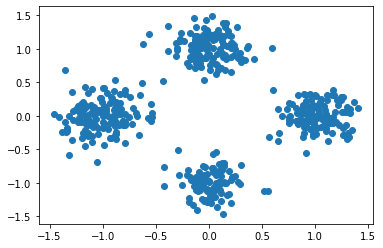

In [3]:
plt.scatter(gaussian_bubbles.data[:500,0], gaussian_bubbles.data[:500,1])


In [8]:
d=4
n=25
dx = 2*d/n
c=[0,0]
x = np.linspace(-d + c[0], d + c[0], n)
y = np.linspace(-d + c[1], d + c[1], n)
# Meshgrid
X,Y = np.meshgrid(x,y)
XYpairs = np.stack([ X.reshape(-1), Y.reshape(-1) ], axis=1)
XYpairs_tensor = torch.from_numpy(XYpairs) + 1e-10 # for numerical stability
t = torch.tensor([0.01]*len(XYpairs_tensor))

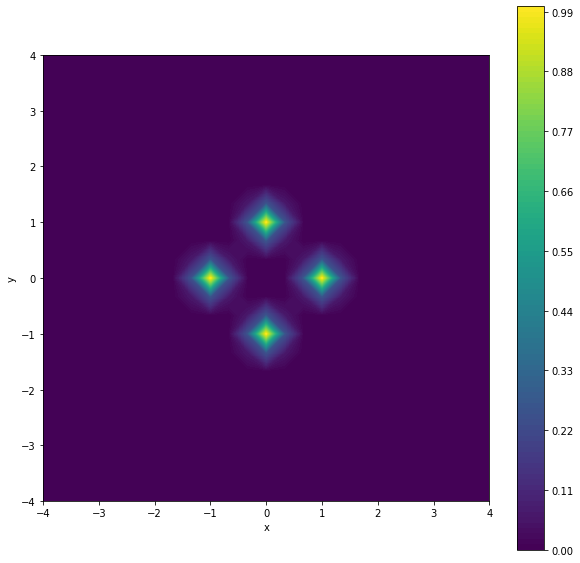

In [15]:
plt.figure(figsize=(10, 10))
Z=data_m.data.log_prob(XYpairs_tensor, t).detach().numpy().reshape(n,n)
Z=np.exp(Z)
plt.contourf(X, Y, Z, levels =100)
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.gca().set_aspect('equal')
plt.show()

Text(0.5, 1.0, 'Ground Truth at t=0.01')

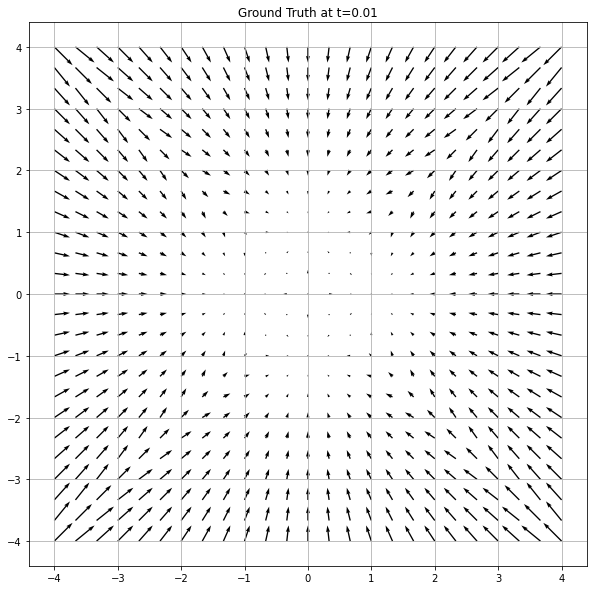

In [13]:
s=data_m.dataset.ground_truth_score(XYpairs_tensor , t)
vector_X=s[:,0].reshape(n,n).detach()
vector_Y=s[:,1].reshape(n,n).detach()
plt.figure(figsize=(10, 10))
plt.quiver(X,Y,vector_X,vector_Y)
plt.grid()
label = str(round(t[0].item(),2))
plt.title('Ground Truth at t=' + label)

In [6]:
s_x = lambda w: data_m.data.ground_truth_score(w , t)
curl = compute_curl(s_x, XYpairs_tensor)

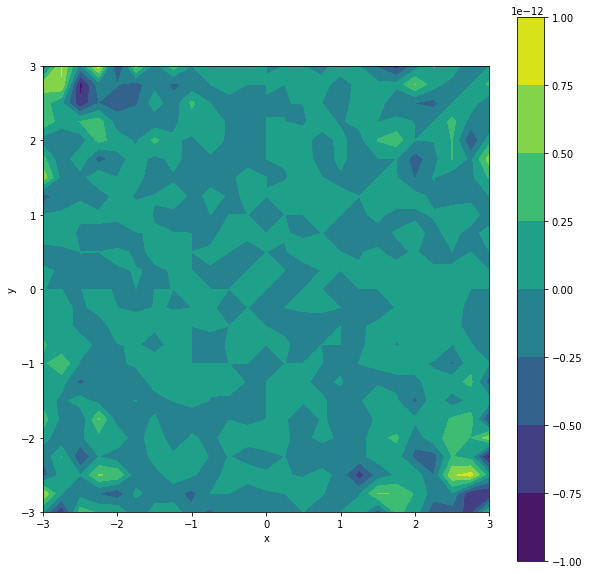

In [7]:
plt.figure(figsize=(10, 10))
Z=curl.detach().numpy().reshape(n,n)
plt.contourf(X, Y, Z)
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.gca().set_aspect('equal')
plt.show()

In [8]:
gt_score = data_m.data.ground_truth_score
x=XYpairs_tensor
eps = 1e-5

n_chunks = 10
x_chunked = torch.chunk(x, n_chunks, dim=0)

t=[]
for x_chunk in x_chunked:
    chunk_size = x_chunk.shape[0]
    t_chunk = torch.rand(1).repeat(chunk_size)
    t.append(t_chunk)
t = torch.cat(t, dim=0)


#t = torch.rand(1, device=batch.device) * (data_m.data.sde.T - eps) + eps
#t = t.repeat(batch.shape[0])
diffusion = data_m.data.sde.sde(torch.zeros_like(x), t)[1]

perturbed_data = data_m.data.sde.perturb(x, t)

gt_log_prob_t = lambda s: data_m.data.log_prob(perturbed_data, s) + torch.sin(s)
gt_score_x = lambda y: gt_score(y,t)

def compute_fp_loss(perturbed_data,t):
    a = torch.linalg.norm(gt_score(perturbed_data, t), dim=1)**2 
    b = compute_divergence(gt_score_x, perturbed_data)
    c = compute_grad(gt_log_prob_t, t).squeeze(1)
    diff = (c - (diffusion**2 / 2) * (a + b))
    weighted_diff = diffusion **2  * diff
    return weighted_diff

In [12]:
x_grad_fp_loss = compute_grad(lambda x: compute_fp_loss(x,t), perturbed_data)
loss = (torch.linalg.norm(x_grad_fp_loss, dim=1)**2).mean()
print(loss.item())

1.2046318688598696e-10


In [15]:
diff = (c - (diffusion**2 / 2) * (a + b))
weighted_diff = diffusion **2  * diff
diff_chunked = torch.chunk(weighted_diff, n_chunks, dim=0)
loss=0
for chunk in diff_chunked:
    chunk = chunk.view(1,chunk.shape[0],1)
    loss += torch.cdist(chunk, chunk).mean()
print('fokker-planck loss = ', loss.item())

fokker-planck loss =  0.000274776574366292


In [ ]:
plt.figure(figsize=(10, 10))
Z=diff.detach().reshape(n,n)
plt.contourf(X, Y, Z)
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.gca().set_aspect('equal')
plt.show()

In [ ]:
# check fokker planck
p = lambda y,s: torch.exp(data_m.data.log_prob(y, s))
x=XYpairs_tensor
t = torch.tensor([0.9]*len(XYpairs_tensor))

In [ ]:
p_t = lambda s: p(x,s)
p_x = lambda y: p(y,t)

dp_dt = compute_grad(p_t, t)
grad_p = lambda x: compute_grad(p_x, x)
laplacian = compute_divergence(grad_p, x)
diffusion = data_m.data.sde.sde(torch.zeros_like(x), t)[1]

In [ ]:
print(dp_dt[0])
print(laplacian[0])
print(diffusion[0]**2 / 2 * laplacian[0])
print((dp_dt - diffusion**2 / 2 * laplacian) )


tensor([5.5801e-14], grad_fn=<SelectBackward>)
tensor(8.6983e-11, dtype=torch.float64, grad_fn=<SelectBackward>)
tensor(5.5801e-14, dtype=torch.float64, grad_fn=<MulBackward0>)
tensor([[ 9.1133e-21, -2.1450e-12, -1.0558e-10,  ..., -3.5489e-08,
         -1.1510e-09, -4.5683e-11],
        [ 2.1450e-12, -3.4379e-20, -1.0343e-10,  ..., -3.5487e-08,
         -1.1488e-09, -4.3538e-11],
        [ 1.0558e-10,  1.0343e-10, -7.1279e-18,  ..., -3.5384e-08,
         -1.0454e-09,  5.9896e-11],
        ...,
        [ 3.5489e-08,  3.5487e-08,  3.5384e-08,  ...,  4.6662e-15,
          3.4338e-08,  3.5444e-08],
        [ 1.1510e-09,  1.1488e-09,  1.0454e-09,  ..., -3.4338e-08,
          1.4870e-16,  1.1053e-09],
        [ 4.5683e-11,  4.3538e-11, -5.9896e-11,  ..., -3.5444e-08,
         -1.1053e-09,  7.6031e-18]], dtype=torch.float64,
       grad_fn=<SubBackward0>)


In [38]:
Y.shape

(25, 25)

In [79]:
diffusion**2

tensor([38.7697, 38.7697, 38.7697,  ..., 38.7697, 38.7697, 38.7697])

In [13]:
XYpairs_tensor.requires_grad

False

In [11]:
model = BaseSdeGenerativeModel.load_from_checkpoint('logs/gaussian_bubbles/lightning_logs/version_1/checkpoints/epoch=6249-step=499999.ckpt')
score = model.score_model
score = score.eval()
model.configure_sde(config)
score_fn = get_score_fn(model.sde, score, train=False, continuous=True)

In [14]:
out=score_fn(XYpairs_tensor.float(), t.float())
out_X = out[... ,0].detach().numpy()
out_Y = out[... ,1].detach().numpy()

In [38]:
plt.figure(figsize=(10, 10))
plt.streamplot(X,Y,out_X,out_Y)
plt.grid()
plt.title('Model')
plt.show()

NameError: name 'out_X' is not defined

<Figure size 720x720 with 0 Axes>

In [17]:
out_X.shape

(10000,)

# Divergence test

In [18]:
from utils import generate_grid
n=200
X, Y = generate_grid(n=n)
XYpairs = np.stack([ X.reshape(-1), Y.reshape(-1) ], axis=1)
XYpairs_tensor = torch.from_numpy(XYpairs)

def f(xs):
    out = []
    for x in xs:
        out.append(torch.stack([x[0]**2 - x[1]**2, 2 * x[0] * x[1]]))
    return(torch.stack(out))
out = f(XYpairs_tensor)

Text(0.5, 1.0, 'Ground Truth')

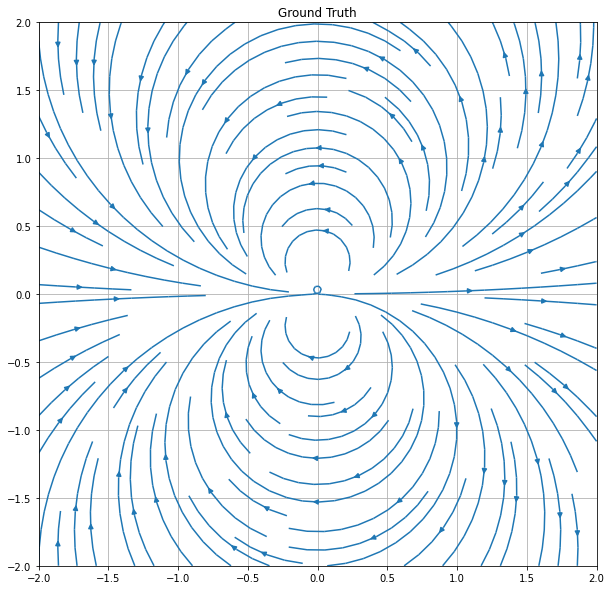

In [19]:
s=out
vector_X=s[:,0].reshape(n,n).detach()
vector_Y=s[:,1].reshape(n,n).detach()
plt.figure(figsize=(10, 10))
plt.streamplot(X,Y,vector_X,vector_Y)
plt.grid()
plt.title('Ground Truth')

In [20]:
diver = compute_divergence(f, XYpairs_tensor)

In [21]:
diver_h = compute_divergence(f, XYpairs_tensor, True)

In [22]:
(diver - diver_h).abs().mean()

tensor(6.4460e-17, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [17]:
diver.abs().mean()

tensor(4.0404, dtype=torch.float64, grad_fn=<MeanBackward0>)